In [3]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import umap

# load files and make corpus

In [6]:
with open('hansard-speeches-post2010-lemmatized-agg.pkl', 'rb') as f:
    df = pickle.load(f)

In [7]:
with open('hansard-speeches-post2010.pkl', 'rb') as f:
    df_orig = pickle.load(f)

In [4]:
# df_test = df.sample(len(df)//10)
# df_test

In [8]:
MP_party = df_orig[['display_as', 'party']]
MP_party = MP_party.drop_duplicates('display_as').set_index('display_as')

In [9]:
names = [x[2] for x in df.index.values]
parties = [MP_party.loc[MP_name].party for MP_name in names]

In [6]:
corpus = list(df.speech.values)
# corpus = list(df.lemmas.apply(lambda x: " ".join(x)).values)

# speech embedding

In [7]:
from sentence_transformers import SentenceTransformer

In [8]:
# embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embedder = SentenceTransformer('paraphrase-mpnet-base-v2')
# embedder = SentenceTransformer('stsb-mpnet-base-v2') #75 max seq length

## count prop. contributions with word/lemma counts above embedder max input sequence length

In [9]:
wordcount = df.speech.apply(lambda x: len(x.split())).values
lemmacount = df.lemmas.apply(len).values

max sequence length: 128
wordcounts above 128: 33.859 %
lemmacounts above 128: 22.3978 %


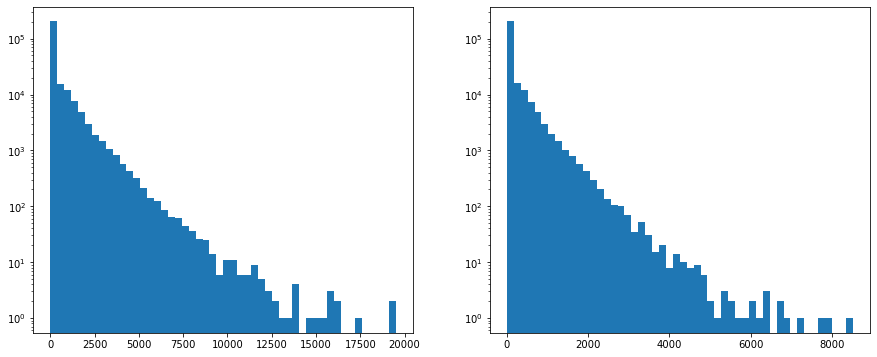

In [10]:
max_seq_len = embedder.max_seq_length
print(f'max sequence length: {max_seq_len}')

fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].hist(wordcount, bins=50)
ax[0].set_yscale('log')
print(f'wordcounts above {max_seq_len}: {np.around((np.sum(wordcount > max_seq_len) / len(wordcount))*100, 4)} %')

ax[1].hist(lemmacount, bins=50)
ax[1].set_yscale('log')
print(f'lemmacounts above {max_seq_len}: {np.around((np.sum(lemmacount > max_seq_len) / len(lemmacount))*100, 4)} %')

plt.show()

In [13]:
# corpus_embeddings = embedder.encode(corpus)
# corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [14]:
# with open('corpus_embeddings.pkl', 'wb') as f:
#     pickle.dump(corpus_embeddings, f)
with open('corpus_embeddings.pkl', 'rb') as f:
    corpus_embeddings = pickle.load(f)

In [15]:
corpus_embeddings.shape

(253820, 768)

In [19]:
from sklearn.decomposition import PCA
pca = PCA(random_state=26)
pca.fit(corpus_embeddings)

PCA(random_state=26)

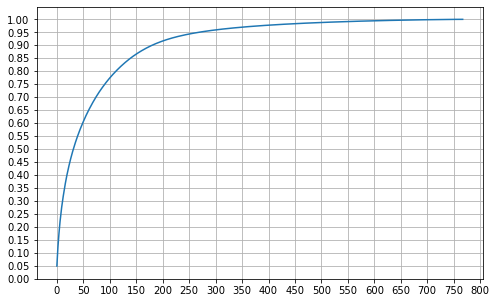

In [35]:
evr = pca.explained_variance_ratio_
cum_evr = [np.sum(evr[:i+1]) for i in range(len(evr))]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cum_evr)
ax.grid()
ax.set_xticks(range(0,801,50))
ax.set_yticks(np.arange(0,1.05,0.05))
plt.show()

In [36]:
embeddings = PCA(n_components=400, random_state=26).fit_transform(corpus_embeddings)

chunking

In [15]:
# def chunker(string, chunksize):
#     words = string.split()
#     return [" ".join(words[pos: pos + chunksize]) for pos in range(0, len(words), chunksize)]

# print(embedder.max_seq_length)

# a = df.sample().speech.values[0]
# print(a)
# b = chunker(a, 5)
# print(b)

umap dimensionality reduction

In [38]:
np.unique(parties)

array(['Alliance', 'Conservative', 'Democratic Unionist Party',
       'Green Party', 'Independent', 'Labour', 'Labour (Co-op)',
       'Liberal Democrat', 'Plaid Cymru', 'Respect',
       'Scottish National Party', 'Social Democratic & Labour Party',
       'Speaker', 'Ulster Unionist Party', 'nan'], dtype='<U32')

In [10]:
party_colormap = {
    'Alliance': '#F6CB2F',
    'Conservative': '#0087DC',
    'Democratic Unionist Party': '#D46A4C',
    'Green Party': '#6AB023',
    'Independent': '#DDDDDD',
    'Labour': '#E4003B',
    'Labour (Co-op)': '#E4003B',
    'Liberal Democrat': '#FAA61A',
    'Plaid Cymru': '#008142',
    'Scottish National Party': '#FDF38E',
    'Social Democratic & Labour Party': '#2AA82C',
    'Speaker': '#FFFFFF',
    'Respect': '#46801c',
    'Ulster Unionist Party': '#70147A',
    'nan': '#FFFFFF'
}

c = [party_colormap[str(x)] for x in parties]

In [40]:
reducer = umap.UMAP(n_neighbors=15, 
                    min_dist=0,
                    metric='cosine',
                    low_memory=True)
X = reducer.fit_transform(embeddings) # dimension reduced embedding

In [4]:
# with open('umap_embeddings.pkl', 'wb') as f:
#     pickle.dump(X, f)
    
with open('umap_embeddings.pkl', 'rb') as f:
    X = pickle.load(f)

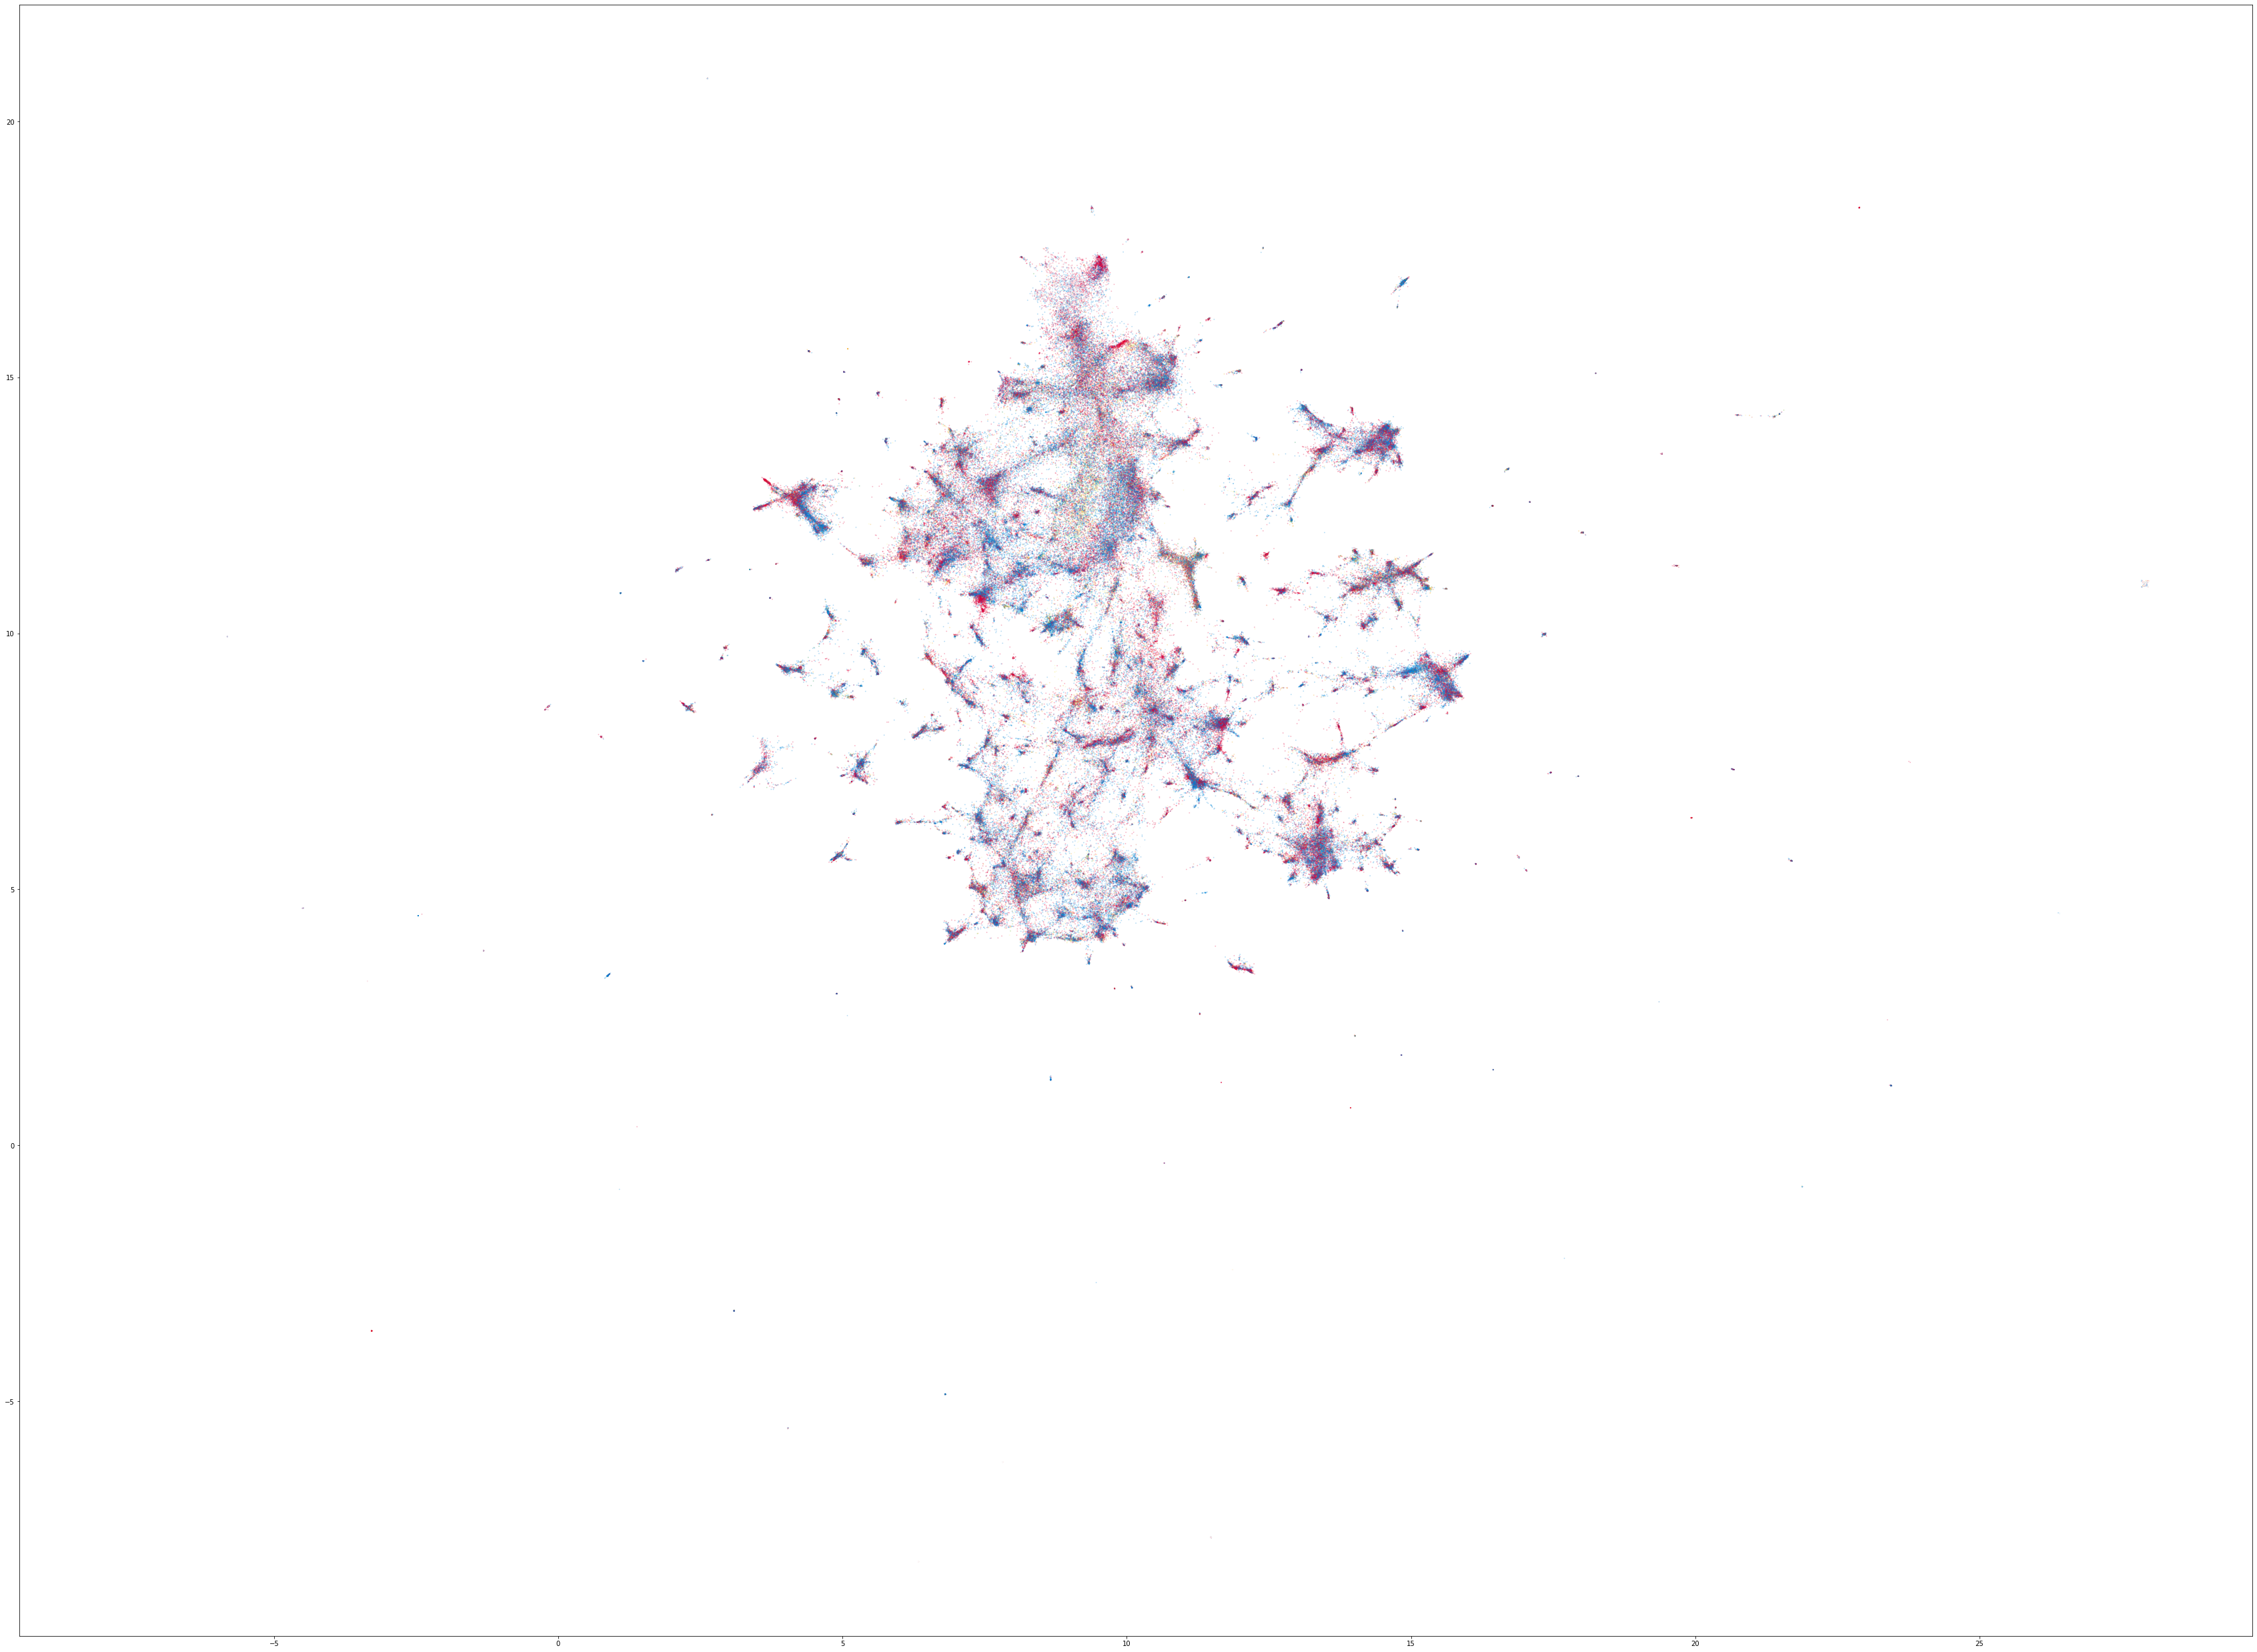

In [13]:
plt.figure(figsize=(60,45))
plt.scatter(X[:,0], X[:,1], s=1, alpha=.2, c=c)#, edgecolors='k', linewidth=0)
plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_2.png', dpi=150)
plt.show()

clustering

In [ ]:
# from sklearn.cluster import DBSCAN
# cluster = 

In [ ]:
# for n in np.arange(5,55,5):
#     reducer = umap.UMAP(n_neighbors=n)
#     embedding_red = reducer.fit_transform(corpus_embeddings)
#     x, y = embedding_red.T

#     colormap = {'Jeremy Corbyn': 'red',
#               'Diane Abbott': 'orange',
#               'Jacob Rees-Mogg': 'green',
#               'Michael Gove': 'blue'}

#     c = [colormap[x] for x in name]

#     plt.figure(figsize=(12,8))
#     plt.title(n)
#     plt.scatter(x,y, s=3, alpha=.7, c=c)
#     plt.show()